<a href="https://colab.research.google.com/github/farid-hamid/DataScience01/blob/main/Topic_Modelling_with_BERTopic_CGM_Device_Opinions_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modelling with BERTopic: CGM Device Opinions Reddit** 🔡📊
---
This notebook walks through the NLP steps and BERTopic model implementations required to perform dimensionality reduction and high-density clustering (with noise) analysis of a text corpus.
​
The dataset consists of posts and comments from popular Diabetes based subReddits where the discussion of Continuous Glucose Monitoring systems and devices are common.
​
# **Context**
*The time period primarily observed is from Summer 2023-early 2024. In Summer of 2023, Abbott Freestyle Libre CGM device received a gradually rolled out software update which allowed the sensor to be used as a continuous glucose monitor, revolutionising daily diabetes management for many people around the world.*
​

---


Links to resources about CGMs:
​

https://www.freestyle.abbott/uk-en/home.html
​

https://www.reddit.com/r/Freestylelibre/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Initial Importing & pip installation of relevant libraries** 📦

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import string

In [ ]:
import nltk

In [ ]:
%pip install umap-learn

In [ ]:
%pip install HDBSCAN

# **Data Cleaning and Natural Language Processing** 🧼📖
*Preparing the text corpus for upcoming topic modelling by normalising the data, removing polluting elements of user-generated data and appropriating document length using spaCy.*

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/FSL_subreddit_posts_data2.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Date of Post         702 non-null    object
 1   Title                702 non-null    object
 2   Body Text            671 non-null    object
 3   Top Comment          701 non-null    object
 4   Top Comment Reply 1  420 non-null    object
 5   Top Comment Reply 2  105 non-null    object
 6   Top Comment Reply 3  32 non-null     object
 7   Top Comment Reply 4  15 non-null     object
dtypes: object(8)
memory usage: 44.0+ KB


In [ ]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Date of Post         702 non-null    object
 1   Title                702 non-null    object
 2   Body Text            671 non-null    object
 3   Top Comment          701 non-null    object
 4   Top Comment Reply 1  420 non-null    object
 5   Top Comment Reply 2  105 non-null    object
 6   Top Comment Reply 3  32 non-null     object
 7   Top Comment Reply 4  15 non-null     object
dtypes: object(8)
memory usage: 44.0+ KB


In [ ]:
data = df

In [ ]:
data.head()

,Date of Post,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4
0,11/10/2023 17:31,Signal loss L3,Any tips signal loss fix Only 2nd day I turned...,"I get a decent amount of signal loss / error, ...",Thanks for responding. It’s been over an hour ...,NaN,NaN,NaN
1,23/10/2023 14:11,"Android issues ""Signal Loss""? Possible fix",Hi So Ive got sensors app reinstalls like tryi...,I am having same issues but with pixel 6. Tha...,NaN,NaN,NaN,NaN
2,12/10/2023 12:39,Can someone please help: permanent signal loss...,UPDATE October 25th 2023 deleting app reinstal...,"Here in the UK, we got the app update a while ...","Thanks you so so much for this, makes sense th...",NaN,NaN,NaN
3,06/10/2023 18:26,Calling support - they keep saying they can't ...,NaN,Yes they are sending you to a shitty call site...,I have found that IF you can get one from Mexi...,NaN,NaN,NaN
4,05/10/2023 04:39,Beeping,Is way turn beeping sound comes unit thinks fa...,[deleted],"I appreciate your feedback, but like I said, I...",NaN,NaN,NaN


In [ ]:
data.fillna('', inplace=True)
data['Discussion'] = data.apply(lambda row: ' '.join(row[['Title', 'Body Text', 'Top Comment', 'Top Comment Reply 1', 'Top Comment Reply 2', 'Top Comment Reply 3', 'Top Comment Reply 4']].values), axis=1)
data['Discussion'] = data['Top Comment'].str.lower()
data['Date of Post'] = pd.to_datetime(data['Date of Post'])
data['Date of Post'] = data['Date of Post'].dt.strftime('%d/%m/%Y')

In [ ]:
data.head()

,Date of Post,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4,Discussion
0,10/11/2023,Signal loss L3,Any tips signal loss fix Only 2nd day I turned...,"I get a decent amount of signal loss / error, ...",Thanks for responding. It’s been over an hour ...,,,,"i get a decent amount of signal loss / error, ..."
1,23/10/2023,"Android issues ""Signal Loss""? Possible fix",Hi So Ive got sensors app reinstalls like tryi...,I am having same issues but with pixel 6. Tha...,,,,,i am having same issues but with pixel 6. tha...
2,10/12/2023,Can someone please help: permanent signal loss...,UPDATE October 25th 2023 deleting app reinstal...,"Here in the UK, we got the app update a while ...","Thanks you so so much for this, makes sense th...",,,,"here in the uk, we got the app update a while ..."
3,10/06/2023,Calling support - they keep saying they can't ...,,Yes they are sending you to a shitty call site...,I have found that IF you can get one from Mexi...,,,,yes they are sending you to a shitty call site...
4,10/05/2023,Beeping,Is way turn beeping sound comes unit thinks fa...,[deleted],"I appreciate your feedback, but like I said, I...",,,,[deleted]


In [ ]:
df2 = data.filter(['Date of Post','Discussion'],axis=1)
df2.head()

,Date of Post,Discussion
0,10/11/2023,"i get a decent amount of signal loss / error, ..."
1,23/10/2023,i am having same issues but with pixel 6. tha...
2,10/12/2023,"here in the uk, we got the app update a while ..."
3,10/06/2023,yes they are sending you to a shitty call site...
4,10/05/2023,[deleted]


In [ ]:
def remove_punctuation_and_emojis(text):
    if not isinstance(text, str):
        #if text is not a string, return it as it is
        return text

    punctuation = string.punctuation
    #punctuation translator
    translator = str.maketrans('', '', string.punctuation)
    #remove punctuation
    text = text.translate(translator)

    #regex pattern for emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  #emoticons
                           u"\U0001F300-\U0001F5FF"  #symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  #transport & map symbols
                           u"\U0001F700-\U0001F77F"  #alchemical symbols
                           u"\U0001F780-\U0001F7FF"  #Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  #Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  #Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  #Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  #Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  #Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #removals

    return text

In [ ]:
df2['Discussion'] = df2['Discussion'].apply(lambda x: remove_punctuation_and_emojis(x))

In [ ]:
#removal of other incoherent chars
def remove_chars(text):

    if isinstance(text, str):
        #replace numbers with empty string, remove nd,rd,st, http and www, any strings longer than 26 chars
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\bnd\b|\b[a-zA-Z]{1,2}\b', '', text)
        text = re.sub(r'\brd\b|\b[a-zA-Z]{1,2}\b', '', text)
        text = re.sub(r'\bst\b|\b[a-zA-Z]{1,2}\b', '', text)
        text = re.sub(r'\bblah\b|\b[a-zA-Z]{1,2,3,4}\b', '', text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'\b\w{26,}\b', '', text)
    return text


In [ ]:
df2['Discussion'] = df2['Discussion'].apply(lambda x: remove_chars(x) if isinstance(x, str) else x)

In [ ]:
df2 = df2[df2['Discussion'].apply(lambda x: len(x) >= 10)] #remove records which are too short and will pollute the model

In [ ]:
def clean_text_digits(text):
    #Tokenize the text into words
    tokens = word_tokenize(text)


    translator = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(translator) for w in tokens]

    #Remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()and len(word) > 2]

    #join the list of words into a single string
    return ' '.join(words)

In [ ]:
df2['Discussion'] = df2['Discussion'].apply(clean_text_digits)
df2.head()

,Date of Post,Discussion
0,10/11/2023,get decent amount signal loss error and experi...
1,23/10/2023,having same issues but with pixel that setting...
2,10/12/2023,here the got the app update while back maybe w...
3,10/06/2023,yes they are sending you shitty call site indi...
5,23/10/2023,help here just commiseration had the same thin...


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 701
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date of Post  686 non-null    object
 1   Discussion    686 non-null    object
dtypes: object(2)
memory usage: 32.2+ KB


In [ ]:
%pip install spacy

In [ ]:
import spacy

#spaCy English model loading
nlp = spacy.load("en_core_web_sm")

In [ ]:
def document_length_splitter(texts, character_threshold=20):

  #parse text using spaCy
  if len(texts) > character_threshold:
        # Parse the text using spaCy to extract sentences
        doc = nlp(texts)
        #Return a list of sentences
        return [sentence.text for sentence in doc.sents]
  else:
        #If the text is not too long, return it as a single-element list
        return [texts]


In [ ]:
df3 = df2.copy()

In [ ]:
df3['Discussion'] = df3['Discussion'].apply(document_length_splitter)

In [ ]:
df3 = df3.explode('Discussion')

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 0 to 701
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date of Post  744 non-null    object
 1   Discussion    744 non-null    object
dtypes: object(2)
memory usage: 17.4+ KB


# **UMAP for Dimensionality Reduction & HDBSCAN for Clustering of topics**🪣
*Sub-model configuration to be fed into BERTopic model.*

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=6, n_components=3, min_dist=0.05, random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=8,
                        prediction_data=True, gen_min_span_tree=True)

In [ ]:
%pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 20.9 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.1 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039291 sha256=b05d173dfc189bc4ccce76fd52aee23b1d7bded25d48adebd3c67e4560ee90e0
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from tqdm.auto import tqdm

In [ ]:
n = len(df3)

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer


# **Stopwords Removal and Initiation of Vectorizer sub model**📑
A list of words which are extremely common in the use case and pollutants to the unsupervised learning algorithm pipeline being implemented. These are injected into the vectorizer sub model.



In [ ]:
from nltk.corpus import stopwords
stopwords = list(stopwords.words('english')) + ['doesn','sensor','sensors','yes','lol','lmao','wtf','abbott','abott','pay','month','medicare', 'cgms', 'fda', 'patients', 'voucher', 'doctor', 'dex','dexcom', 'authorization', 'cost', 'service','medical','covered','freestyle','company','tempo','glucose','cover','mgdl','reading','lot','wanting','want','hours','months','question','since','day','night','first','last','started','ago','dont','using','use','loss','around','new','phone','put','days','app', 'mmol','mmoll', 'drug','heck','the','http', 'https', 'amp', 'com', 'one', 'www', 'anyone', 'can', 'CVS', 'insurance', 'get', 'like', 'back', 'ive', 'would', 'omnipod', 'pharmacy', 'medtronic', 'to', 'turn','up','out','price', 'cgm','sugar','finger','prick','time','really','else','anybody','wait','blood','also','insulin','know','still','feel','got','thank','thanks','think','numbers','stick','going','check','about','even','too','always','much','be','how','yeah','pocket','yeah yeah','for','months']
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words=stopwords)

# **Embedding Text with Sentence Transformers**🤖
*Leveraging sentence transformers, documents in the text corpus are embedded in small batches for quality. These embeddings are saved in the* embeds *variable for later on, when the topic labels are extracted and they can be combined with the embedded dataset.*

In [ ]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeds = np.zeros((n, embedding_model.get_sentence_embedding_dimension()))
texts = df3['Discussion'].tolist()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
batch_size=10

In [ ]:
 for i in tqdm(range(0,n,batch_size)):
     i_end = min(i+batch_size,n)
     batch = df3['Discussion'].iloc[i:i_end].tolist()
     batch_embed = embedding_model.encode(batch)
     embeds[i:i_end,:] = batch_embed

  0%|          | 0/75 [00:00<?, ?it/s]

# **Representation sub-models**🌍
*Using keyBERT and Maximal Marginal Relevance to generate coherent topic labels which describe the pain point narrative in a piece of dialogue.*

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration
from transformers import pipeline

In [ ]:
keybert = KeyBERTInspired()
mmr = MaximalMarginalRelevance(diversity=0.3)

representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr,
}

# **BERTopic Model**💻
---
*The BERTopic model, consisting of a pipeline of unsupervised machine learning algorithms through its UMAP (dimensionality reduction), HDBSCAN (clustering with noise), text embedding, vectorisation and represenation sub-models, is initiated and trained below.*


In [ ]:
BERTopic_model = BERTopic(
    #sub-models:
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    #hyper-parameters:
    min_topic_size = 10,#careful with tuning this parameter
    top_n_words=15,
    #nr_topics= 8,
    language='english',
    calculate_probabilities=True,
    verbose=True,


)
#model.fit(data['Discussion'])
#topics, probs = model.fit_transform(data['Discussion'])

#Train model:
topics, probs = BERTopic_model.fit_transform(texts, embeddings=embeds)

2024-03-10 14:10:57,591 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-10 14:11:01,202 - BERTopic - Dimensionality - Completed ✓
2024-03-10 14:11:01,205 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-10 14:11:01,252 - BERTopic - Cluster - Completed ✓
2024-03-10 14:11:01,261 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-10 14:11:12,332 - BERTopic - Representation - Completed ✓


In [ ]:
# for i in range(5):
#     print(f"{topics[i]}: {df3['Discussion'][i]}")

In [ ]:
BERTopic_model.visualize_barchart()

In [ ]:
BERTopic_model.visualize_hierarchy()

In [ ]:
#run this cell if rows are removed in NLP text cleaning, the index needs to be reset for visualize_documents() function to work
df3.reset_index(drop=True, inplace=True)

In [ ]:
df3['Topic'] = topics
timestamps = df3['Date of Post'].astype(str).tolist()
topics = df3['Topic'].astype(str).tolist()



In [ ]:
topics_over_time = BERTopic_model.topics_over_time(topics,timestamps)

2024-03-10 14:11:48,206 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 289) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
289it [00:08, 32.47it/s]


*By visualising Topics over Time, it is observable that after the significant software update in Summer of 2023, a stream of opinionated discussion and advice/knowledge sharing followed. The Global Topic Representations serve as a base for contextual insights into what Diabetics are feeling and discussing concerning their daily self-management and pain points with their glucose monitoring sensor systems.*

In [ ]:
#BERTopic_model.visualize_topics_over_time(topics_over_time,topics)

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
BERTopic_model.visualize_documents(df3['Discussion'], embeddings=embeds)

<Axes: ylabel='$\\lambda$ value'>

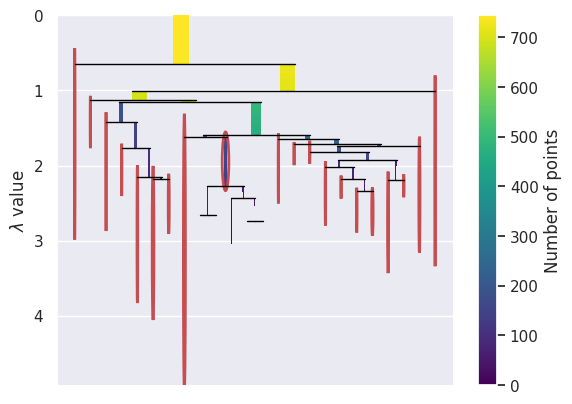

In [ ]:
hdbscan_model.condensed_tree_.plot(select_clusters=True)

In [ ]:
import plotly.express as px

In [ ]:
assert len(topics) == len(df3)

In [ ]:
#df3['Topic'] = topics

In [ ]:
df3.head()

,Date of Post,Discussion,Topic
0,10/11/2023,get decent amount signal loss error and experi...,-1
1,23/10/2023,having same issues but with pixel that setting...,-1
2,10/12/2023,here the got the app update while back maybe w...,9
3,10/12/2023,well ive got through two the new ones which ha...,0
4,10/06/2023,yes they are sending you shitty call site indi...,-1


***As seen below, we have imbalanced topic classes, which is expected from such a diverse text corpus scraped from social media.***

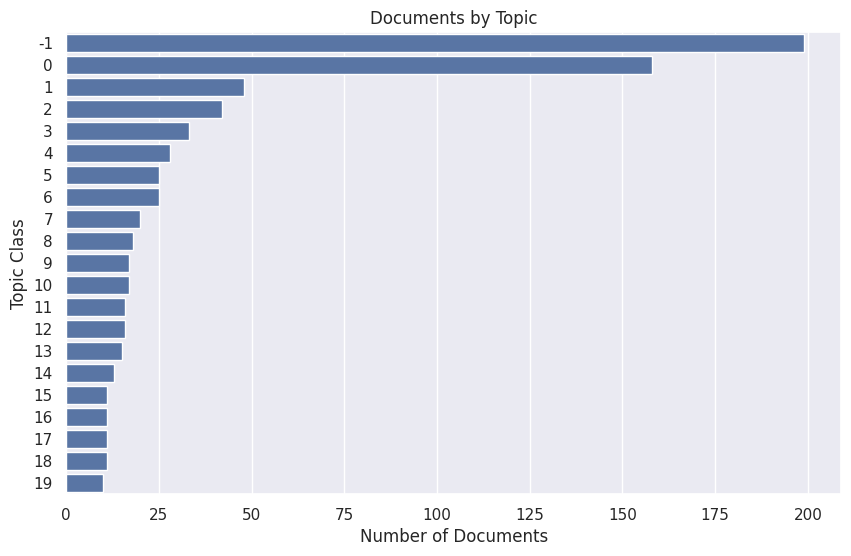

In [ ]:
topic_counts = df3['Topic'].value_counts()
#data.drop(['Contains_Keywords'], axis=1)
#Create a count plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(y='Topic', data=df3, order = topic_counts.index)

#Labeling the plot
plt.title('Documents by Topic')
plt.xlabel('Number of Documents')
plt.ylabel('Topic Class')

#Show the plot
plt.show()

In [ ]:
topic_distr, _ = BERTopic_model.approximate_distribution(texts)

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


In [ ]:
#BERTopic_model.visualize_distribution(topic_distr[1])
BERTopic_model.visualize_distribution(probs)

ValueError: This visualization cannot be used if you have set `calculate_probabilities` to False as it uses the topic probabilities of all topics. 

In [ ]:
probs

array([[3.00986820e-002, 1.69899668e-002, 4.32565990e-002, ...,
        3.75675439e-002, 2.13643278e-002, 6.22153203e-002],
       [1.90888635e-002, 9.08414495e-003, 6.36591346e-002, ...,
        4.44954683e-002, 1.32970832e-002, 2.62550617e-002],
       [5.09191151e-308, 1.48124826e-308, 3.83181922e-308, ...,
        5.20464732e-308, 1.94049542e-308, 4.24686020e-308],
       ...,
       [2.44343000e-308, 1.06785625e-308, 7.21556286e-308, ...,
        6.50796880e-308, 1.63522329e-308, 2.31165967e-308],
       [2.44998894e-308, 2.39579218e-308, 2.25669966e-308, ...,
        2.68041413e-308, 1.00000000e+000, 2.71988058e-308],
       [3.09089125e-002, 2.31927367e-002, 1.57819565e-002, ...,
        1.95318191e-002, 2.35044205e-002, 3.38990020e-002]])

In [ ]:
topic_distr, topic_token_distr = BERTopic_model.approximate_distribution(texts, calculate_tokens=True)
topic_dist_df = BERTopic_model.visualize_approximate_distribution(texts[1], topic_token_distr[1])


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


In [ ]:
topic_dist_df

,having,same,issues,but,with,pixel,that,setting,not,there,the,pixel,anyone,else,having,this,issue,have,any,fixes


In [ ]:
BERTopic_model.visualize_term_rank(log_scale=True)

# **BERTopic Model Output Evaluation**🧪
---



# **Coherence**
*By qualitatively comparing the representations generated by the topic model, it is evident that they are coherent and diverse, where each topic is represented by uniques phrases and terms related to specific niches in CGMs usage.*

In [ ]:
coherence = BERTopic_model.get_topic_info(); coherence.head(10)

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,199,-1_libre_dexcom_readings_never,"[libre, dexcom, readings, never, signal, need,...","[bluetooth, ios, scan, readings, iphone, devic...","[libre, dexcom, readings, signal, minutes, rea...",[yes have using iphone pro max now ios abbotts...
1,0,158,0_skin_readings_adhesive_bad,"[skin, readings, adhesive, bad, replacement, s...","[accuracy, inaccurate, readings, activation, s...","[skin, readings, adhesive, bad, replacement, s...",[never used the libre only the freedom libre l...
2,1,48,1_arm_compression_lows_side,"[arm, compression, lows, side, compression low...","[compression low alarms, low alarms, experienc...","[arm, compression, lows, compression lows, com...",[you sleeping your side and that the side wher...
3,2,42,2_libre_bluetooth_nfc_android,"[libre, bluetooth, nfc, android, device, libre...","[libre connect device, devices libre connect, ...","[libre, bluetooth, libre connect, connect devi...",[was told tandem rep that the libre would inte...
4,3,33,3_average_different_sticks_minutes,"[average, different, sticks, minutes, gmi, tes...","[average makes difference, difference accurate...","[average, sticks, minutes, gmi, test, fluid, i...",[hear many complain inaccuracies libre always ...
5,4,28,4_alarm_low_alert_low alarm,"[alarm, low, alert, low alarm, went, turned, s...","[alarms turned signal, alarm simply alarms, tu...","[alarm, alert, low alarm, alarms, signal, morn...",[yes you can adjust the level that triggers th...
6,5,25,5_try_update_fine_space,"[try, update, fine, space, model, version, rei...","[reinstall might able, nothing fixed, hoping u...","[try, update, fine, space, model, reinstall, w...",[good see not alone this tried everything can ...
7,6,25,6_dexcom_calibration_low_calibrate,"[dexcom, calibration, low, calibrate, differen...","[dexcom read, difference dexcom, dexcom, meter...","[dexcom, calibrate, readings, contact dexcom, ...",[yup saw comment recently similar post that sa...
8,7,20,7_prescription_bad_ones_expired,"[prescription, bad, ones, expired, batch, bad ...","[prescription need, prescription need see, pre...","[prescription, expired, bad ones, bad batch, e...",[contact abbott labs you likely have some from...
9,8,18,8_watch_data_xdrip_juggluco,"[watch, data, xdrip, juggluco, garmin, watches...","[apple watch, smart watches, smartwatch, direc...","[data, juggluco, garmin, watches, apps, apple ...",[yet dexcom only allows that data flow through...


In [ ]:
coherence_df = coherence

In [ ]:
coherence_df

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,199,-1_libre_dexcom_readings_never,"[libre, dexcom, readings, never, signal, need,...","[bluetooth, ios, scan, readings, iphone, devic...","[libre, dexcom, readings, signal, minutes, rea...",[yes have using iphone pro max now ios abbotts...
1,0,158,0_skin_readings_adhesive_bad,"[skin, readings, adhesive, bad, replacement, s...","[accuracy, inaccurate, readings, activation, s...","[skin, readings, adhesive, bad, replacement, s...",[never used the libre only the freedom libre l...
2,1,48,1_arm_compression_lows_side,"[arm, compression, lows, side, compression low...","[compression low alarms, low alarms, experienc...","[arm, compression, lows, compression lows, com...",[you sleeping your side and that the side wher...
3,2,42,2_libre_bluetooth_nfc_android,"[libre, bluetooth, nfc, android, device, libre...","[libre connect device, devices libre connect, ...","[libre, bluetooth, libre connect, connect devi...",[was told tandem rep that the libre would inte...
4,3,33,3_average_different_sticks_minutes,"[average, different, sticks, minutes, gmi, tes...","[average makes difference, difference accurate...","[average, sticks, minutes, gmi, test, fluid, i...",[hear many complain inaccuracies libre always ...
5,4,28,4_alarm_low_alert_low alarm,"[alarm, low, alert, low alarm, went, turned, s...","[alarms turned signal, alarm simply alarms, tu...","[alarm, alert, low alarm, alarms, signal, morn...",[yes you can adjust the level that triggers th...
6,5,25,5_try_update_fine_space,"[try, update, fine, space, model, version, rei...","[reinstall might able, nothing fixed, hoping u...","[try, update, fine, space, model, reinstall, w...",[good see not alone this tried everything can ...
7,6,25,6_dexcom_calibration_low_calibrate,"[dexcom, calibration, low, calibrate, differen...","[dexcom read, difference dexcom, dexcom, meter...","[dexcom, calibrate, readings, contact dexcom, ...",[yup saw comment recently similar post that sa...
8,7,20,7_prescription_bad_ones_expired,"[prescription, bad, ones, expired, batch, bad ...","[prescription need, prescription need see, pre...","[prescription, expired, bad ones, bad batch, e...",[contact abbott labs you likely have some from...
9,8,18,8_watch_data_xdrip_juggluco,"[watch, data, xdrip, juggluco, garmin, watches...","[apple watch, smart watches, smartwatch, direc...","[data, juggluco, garmin, watches, apps, apple ...",[yet dexcom only allows that data flow through...


In [ ]:
# @title Topic vs Count

from matplotlib import pyplot as plt
coherence.plot(kind='scatter', x='Topic', y='Count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df3.to_excel('/content/drive/MyDrive/Colab Notebooks/BERTopic Model Outputs.xlsx')

In [ ]:
coherence_df.to_excel('/content/drive/MyDrive/Colab Notebooks/BERTopic Coherence.xlsx')

# **Topic Reduction**


---

*Merging similar topics*

In [ ]:
merged_topics, merged_probs = BERTopic_model.reduce_topics(texts,topics,probs,embeds)